**Table of contents**<a id='toc0_'></a>    
1. [Efficient Supply Allocation in Ride-Hailing](#toc1_)    
1.1. [Introduction](#toc1_1_)    
1.1.1. [Problem Statement](#toc1_1_1_)    
1.1.2. [Dataset Overview](#toc1_1_2_)    
1.1.3. [Task Overview](#toc1_1_3_)    
2. [Importing Dependencies](#toc2_)    
3. [Data Loading and Exploration](#toc3_)    
3.1. [Loading the Dataset](#toc3_1_)    
3.2. [Initial Exploration](#toc3_2_)    
3.3. [Data Cleaning](#toc3_3_)    
4. [Spatial Clustering with k-means](#toc4_)    
4.1. [K-means Clustering](#toc4_1_)    
5. [Polygon Generation](#toc5_)    
5.1. [Polygon visualization](#toc5_1_)    
5.2. [Polygon visualization with an underlying map](#toc5_2_)    
6. [Efficient Supply Allocation Solution](#toc6_)    
6.1. [Feature Engineering](#toc6_1_)    
6.2. [Exploring Demand Patterns](#toc6_2_)    
7. [Building a Baseline Model](#toc7_)    
7.1. [Allocating Resources](#toc7_1_)    
7.2. [Design and Deployment of the Model](#toc7_2_)    
7.3. [Model Documentation](#toc7_3_)    
7.3.1. [Baseline Model Information:](#toc7_3_1_)    
7.3.2. [Model Deployment Considerations](#toc7_3_2_)    
7.3.3. [Communication of Model Recommendations](#toc7_3_3_)    
8. [Designing the Experiment for Validation](#toc8_)    
8.1. [Experimental Design](#toc8_1_)    
8.2. [Metrics for Evaluation](#toc8_2_)    
8.3. [Analysis and Iteration](#toc8_3_)    
9. [Conclusion](#toc9_)    
9.1. [Key Findings](#toc9_1_)    
9.2. [Next Steps](#toc9_2_)    
10. [Additional data that could prove useful](#toc10_)    
11. [References](#toc11_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Efficient Supply Allocation in Ride-Hailing](#toc0_)

The success of a ride-hailing platform relies heavily on the efficient matching of supply and demand in real time. In this notebook, we address the challenge of efficient supply allocation, aiming to ensure that riders can always find a ride while drivers maintain stable earnings. Specifically, we explore the dynamics of ride demand over time and space to guide drivers toward areas with higher expected demand.

---

## 1.1. <a id='toc1_1_'></a>[Introduction](#toc0_)


### 1.1.1. <a id='toc1_1_1_'></a>[Problem Statement](#toc0_)

The primary goal is to develop a solution that leverages data science techniques to allocate drivers effectively based on historical ride demand patterns. We will utilize a synthetic ride demand dataset, resembling real-life scenarios in the city of Tallinn, Estonia.

### 1.1.2. <a id='toc1_1_2_'></a>[Dataset Overview](#toc0_)

The dataset includes the following key columns:
> - `start_time`: Time when the ride order was made.
> - `start_lat`: Latitude of the order's pick-up point.
> - `start_lng`: Longitude of the order's pick-up point.
> - `end_lat`: Latitude of the order's destination point.
> - `end_lng`: Longitude of the order's destination point.
> - `ride_value`: How much monetary value is in this particular ride.

### 1.1.3. <a id='toc1_1_3_'></a>[Task Overview](#toc0_)

For this task, we are expected to:

> 1. Explore the data and suggest a solution to guide the drivers towards areas with higher expected demand at given time and location
> 2. Build and document a baseline model for your solution
> 3. Describe how you would design and deploy such a model
> 4. Describe how to communicate model recommendations to drivers
> 5. Think through and describe the design of the experiment  that would validate your solution for live operations taking into account marketplace specifics

Let's begin by importing the project's dependencies, loading, and exploring the dataset to gain insights into the spatial and temporal patterns of ride demand.


---
# 2. <a id='toc2_'></a>[Importing Dependencies](#toc0_)

In [1]:
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from shapely.geometry import MultiPoint
import folium
from datetime import datetime, timedelta

---

# 3. <a id='toc3_'></a>[Data Loading and Exploration](#toc0_)

## 3.1. <a id='toc3_1_'></a>[Loading the Dataset](#toc0_)

> Loading the dataset and getting a quick overview.

In [2]:
rides_df = pd.read_csv("robotex5.csv")
rides_df.sample(10)

start_time  start_lat  start_lng    end_lat  \
403471  2022-03-28 13:32:40.199267000  59.411298  24.742519  59.425615   
5897    2022-03-21 19:25:22.254226999  59.436456  24.766955  59.425087   
488924  2022-03-25 04:13:08.584557000  59.405681  24.624187  59.414285   
493225  2022-03-19 15:19:08.904827000  59.423400  24.678914  59.420766   
495058  2022-03-25 11:43:59.092465000  59.435166  24.746595  59.410430   
201130  2022-03-15 18:05:35.513000000  59.397156  24.669869  59.401307   
405914  2022-03-19 18:54:16.464455000  59.408235  24.689005  59.430372   
59092   2022-03-16 20:21:37.883503000  59.345476  24.614123  59.411877   
306318  2022-03-28 12:36:07.115000000  59.408655  24.669375  59.428581   
330361  2022-03-20 18:02:43.126000000  59.418221  24.738785  59.431831   

          end_lng  ride_value  
403471  24.729695    0.435250  
5897    24.780559    0.367500  
488924  24.816485    2.678750  
493225  24.800316    1.686000  
495058  24.681855    1.130500  
201130  24.697321    0.407336  
405914  24.736045    0.896250  
59092   24.741886    2.556750  
306318  24.794178    1.815151  
330361  24.858094    1.695927

## 3.2. <a id='toc3_2_'></a>[Initial Exploration](#toc0_)
>To better understand the structure and content of the data, we can get a `general view`, information on `column types`, number of `null records`, `min/max` values, and other `key metrics`. 
>
>We will also generate some plots to help us understand the `data distribution`.

In [3]:
# Count of null values, data types
rides_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627210 entries, 0 to 627209
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   start_time  627210 non-null  object 
 1   start_lat   627210 non-null  float64
 2   start_lng   627210 non-null  float64
 3   end_lat     627210 non-null  float64
 4   end_lng     627210 non-null  float64
 5   ride_value  627210 non-null  float64
dtypes: float64(5), object(1)
memory usage: 28.7+ MB


In [4]:
# Key insights
rides_df.describe()

start_lat      start_lng        end_lat        end_lng  \
count  627210.000000  627210.000000  627210.000000  627210.000000   
mean       59.428682      24.743468      59.397797      24.724847   
std         0.021764       0.056872       1.392755       1.650709   
min        59.321557      24.505199     -37.819979    -122.453962   
25%        59.418803      24.713140      59.415215      24.707919   
50%        59.432069      24.744674      59.430697      24.744335   
75%        59.439024      24.768115      59.439262      24.773924   
max        59.566998      24.973743      61.552744     144.966110   

          ride_value  
count  627210.000000  
mean        2.261384  
std        44.889892  
min         0.107628  
25%         0.545250  
50%         1.059000  
75%         1.712000  
max      3172.701000

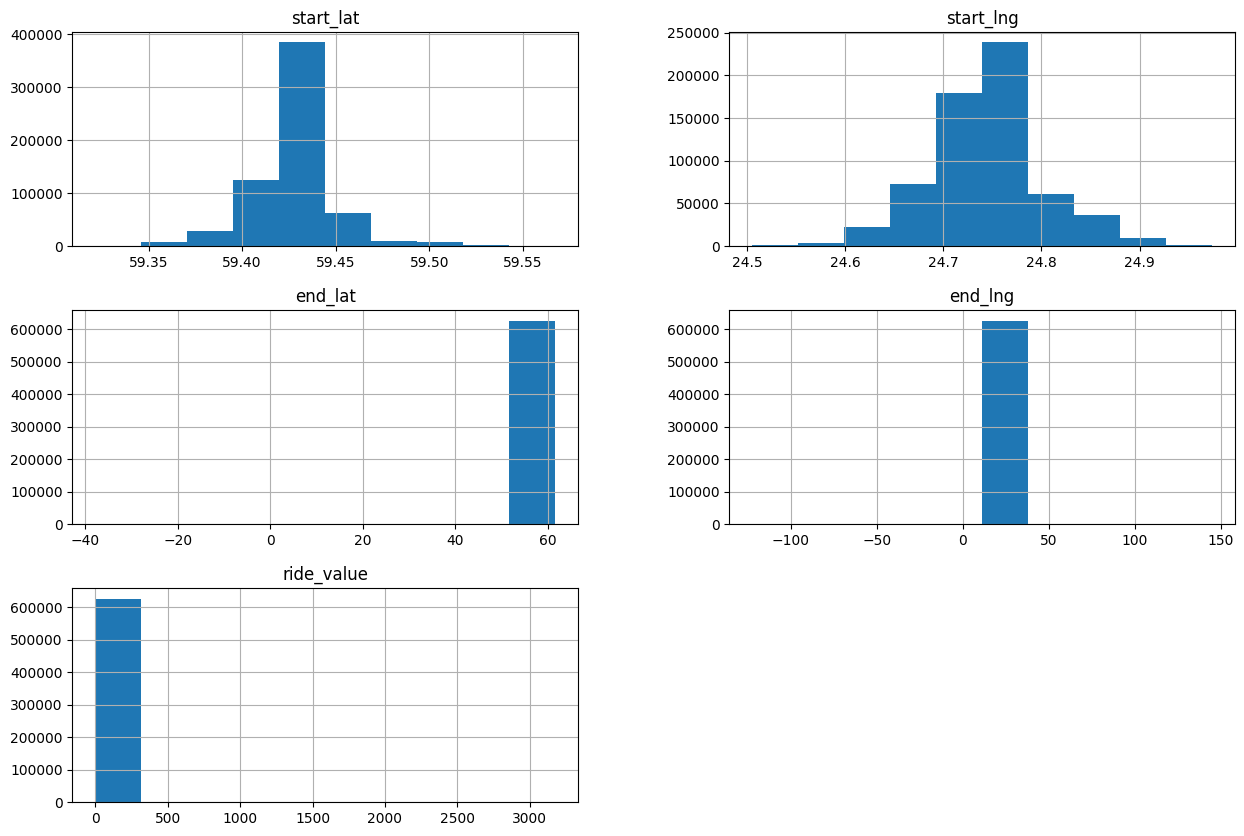

In [5]:
# Features distribution
rides_df.hist(figsize=(15, 10));

## 3.3. <a id='toc3_3_'></a>[Data Cleaning](#toc0_)

We can see above that there are some outliers in the end coordinates and ride values.

At first, we will filter out any locations outside the box in the figure ([source](http://bboxfinder.com/#57.504493,21.211130,59.712541,29.011423)).

![tallinn_bbox](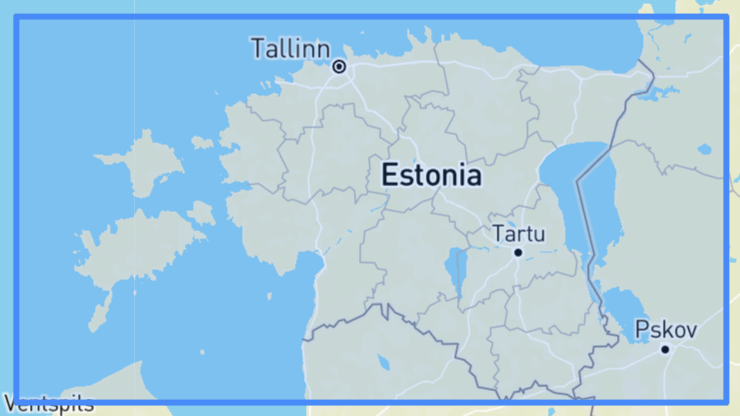
)

In [6]:
# Check for coordinates outside the bounding box described above
bounds_lat = (57.504493, 59.712541)
bounds_lng = (21.211130, 29.011423)

# Remove invalid coordinates
valid_coordinates_mask = (rides_df["start_lat"].between(*bounds_lat)) & (rides_df["start_lng"].between(*bounds_lng)) &  \
                    (rides_df["end_lat"].between(*bounds_lat)) & (rides_df["end_lng"].between(*bounds_lng))

rides_df = rides_df[valid_coordinates_mask]

print("Removed coordinates outside limits:", (~valid_coordinates_mask).sum())

Removed coordinates outside limits: 435


>  
>To address the remaining outliers we will use z-scores, with a threshold of 3:
>  
>Using a threshold of Z-scores greater than 3 or less than -3 is a stricter criterion for identifying outliers. Data points that exceed this threshold are considered highly unusual and are typically reserved for identifying extreme outliers, which
are visible in our data.
>  
  

In [7]:
# Adding distance to help identify outliers
rides_df["distance"] = np.sqrt((rides_df["end_lat"] - rides_df["start_lat"])**2 + (rides_df["end_lng"] - rides_df["start_lng"])**2)

# Calculate z-scores for end coordinates and distance
z_scores_lng = zscore(rides_df["end_lng"])
z_scores_lat = zscore(rides_df["end_lat"])
z_scores_distance = zscore(rides_df["distance"])

# Defining a threshold for z-scores as mentioned above
threshold = 3

# Identify and remove outliers
outliers = (abs(z_scores_lng) >= threshold) |\
            (abs(z_scores_lat) >= threshold) |\
            (abs(z_scores_distance) >= threshold)

rides_df = rides_df[~outliers]

print("Removed outliers:", outliers.values.sum())

Removed outliers: 10177


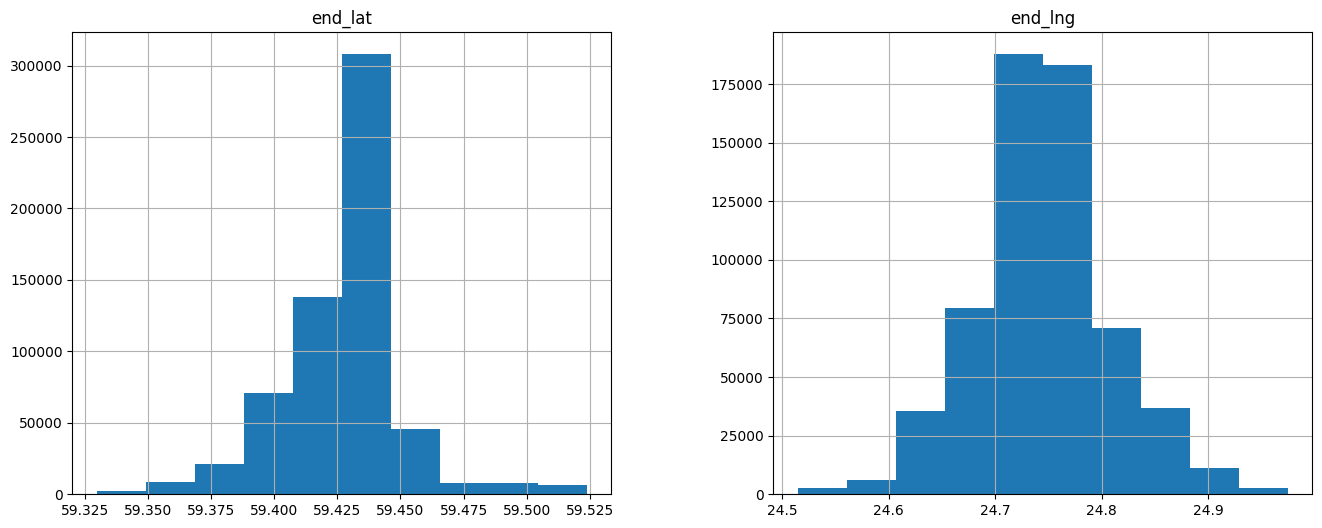

In [8]:
# End coordinates distribution after cleaning
rides_df[["end_lat", "end_lng"]].hist(figsize=(16, 6));

# 4. <a id='toc4_'></a>[Spatial Clustering with k-means](#toc0_)

> In this step, we will apply k-means clustering to the geographical coordinates (latitude and longitude) of the ride data. The clusters generated will help us identify distinct regions with similar ride demand patterns.

## 4.1. <a id='toc4_1_'></a>[K-means Clustering](#toc0_)

> Let's start by applying k-means clustering to the spatial coordinates. We'll use the latitude (`start_lat`) and longitude (`start_lng`) columns for this purpose.
> 
> To choose the ideal number of clusters, we will use the elbow curve method. 

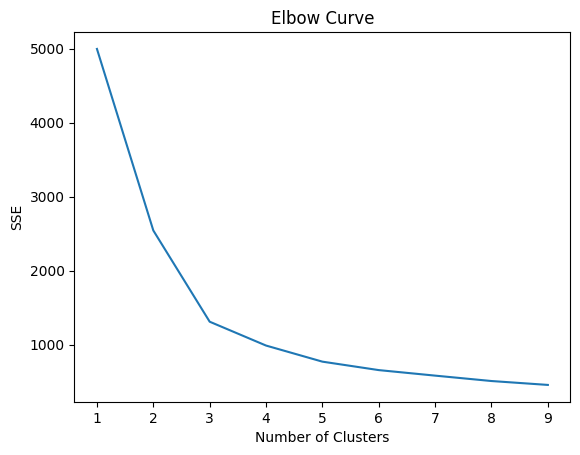

In [9]:
k_clusters = range(1,10)
k_means_list = [KMeans(n_clusters=i, random_state=42) for i in k_clusters]

start_coordinates = rides_df[["start_lat", "start_lng"]].rename(columns = {"start_lat":"lat", "start_lng":"lng"})
end_coordinates = rides_df[["end_lat", "end_lng"]].rename(columns = {"end_lat":"lat", "end_lng":"lng"})
coordinates = pd.concat([start_coordinates, end_coordinates], axis=0)

fitted_models = [model.fit(coordinates) for _, model in enumerate(k_means_list)]
sse = [model.inertia_ for _, model in enumerate(fitted_models)]

# Plot the elbow curve, to choose the ideal number of clusters
plt.plot(k_clusters, sse)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Curve")
plt.show()

In [10]:
# After choosing the ideal number of clusters we use that model to populate our start_cluster column
n_clusters = 5
k_means = fitted_models[n_clusters-1]
rides_df["start_cluster"] = k_means.predict(start_coordinates)
rides_df["end_cluster"] = k_means.predict(end_coordinates)

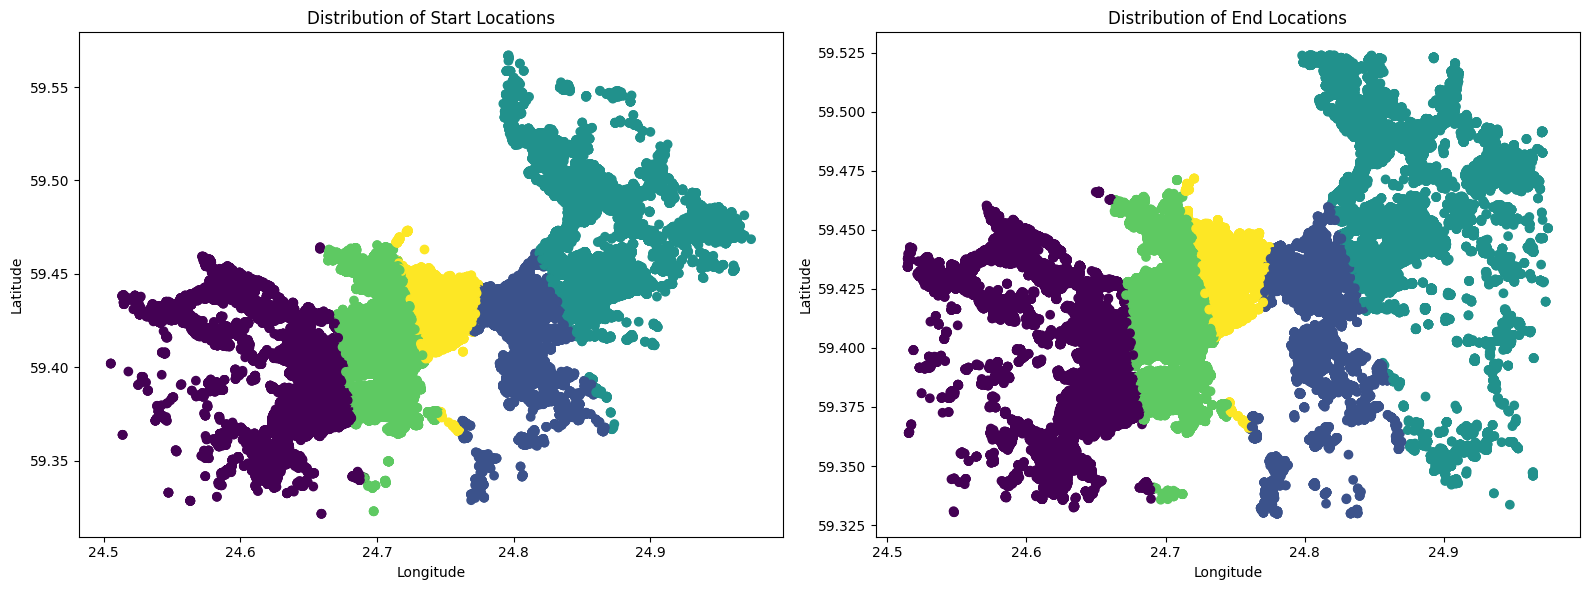

In [11]:
# Plotting the start and end clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(rides_df["start_lng"], rides_df["start_lat"], c=rides_df["start_cluster"])
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].set_title("Distribution of Start Locations")

axes[1].scatter(rides_df["end_lng"], rides_df["end_lat"], c=rides_df["end_cluster"])
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].set_title("Distribution of End Locations")

plt.tight_layout()
plt.show()

# 5. <a id='toc5_'></a>[Polygon Generation](#toc0_)

> Now that we have identified spatial clusters using k-means, the next step is to create non-overlapping polygons around each cluster. These polygons will represent the regions where we aim to guide drivers based on historical ride demand patterns, for this we will use the `start coordinates` and `start_cluster`.
>
> We can achieve this by utilizing the `convex hull` of a set of points in a 2D plane, this is the smallest polygon that contains all the points.

In [12]:
polygons = []
for i in range(n_clusters):
    cluster_points = rides_df[rides_df["start_cluster"] == i][["start_lng", "start_lat"]].values
    multi_point = MultiPoint(cluster_points)
    polygons.append(multi_point.convex_hull)

## 5.1. <a id='toc5_1_'></a>[Polygon visualization](#toc0_)

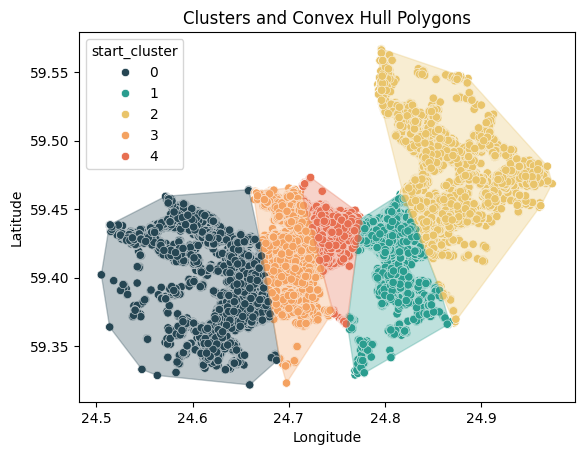

In [13]:
# Defining color for the clusters
colors = {0:"#264653", 1:"#2a9d8f", 2:"#e9c46a", 3:"#f4a261", 4:"#e76f51"}

sns.scatterplot(data=rides_df, x="start_lng", y="start_lat",hue="start_cluster", palette=colors)

# Plot convex hull polygons
for i, polygon in enumerate(polygons):
    x, y = polygon.exterior.xy
    plt.fill(x, y, alpha=0.3, color=colors[i])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clusters and Convex Hull Polygons")
plt.show()

## 5.2. <a id='toc5_2_'></a>[Polygon visualization with an underlying map](#toc0_)

In [14]:
m = folium.Map(
    location=[rides_df["start_lat"].median(), rides_df["start_lng"].median()],
    zoom_start=10.5,
    )

rides_df.sample(frac=0.01).apply(
        lambda row:
            folium.CircleMarker(
                location=[row["start_lat"], row["start_lng"]], 
                radius=3,
                color = colors[row["start_cluster"]],
                fill_color = "#a9a9a9",
            ).add_to(m), axis=1
    )

for i, polygon in enumerate(polygons):
    folium.GeoJson(
        polygon.__geo_interface__,  
        style={
            "fillColor": colors[i],
            "fillOpacity": 0.3,
            "color": colors[i]
        }).add_to(m)

m

---
# 6. <a id='toc6_'></a>[Efficient Supply Allocation Solution](#toc0_)

> With the spatial clusters and non-overlapping polygons in place, we can now explore data to understand demand patterns over time and space. Our goal is to build a baseline model for efficient supply allocation.

## 6.1. <a id='toc6_1_'></a>[Feature Engineering](#toc0_)

> For the next steps, we will need some new features and change the data type of start_time, so we can work with it using pandas.

In [15]:
# Change the start_time to datetime
rides_df["start_time"] = pd.to_datetime(rides_df["start_time"])
# Add day of the week to the data
rides_df["day_of_week"] = rides_df["start_time"].dt.dayofweek
# Add hour of the day
rides_df["hour_of_day"] = rides_df["start_time"].dt.hour
# Add a boolean value for is weekend
rides_df["is_weekend"] = (rides_df["day_of_week"] >= 5)

## 6.2. <a id='toc6_2_'></a>[Exploring Demand Patterns](#toc0_)

>Let's start by examining how demand changes over time and space within each identified cluster. This analysis will guide the development of our solution.
>
>For demand, we could use ride_value or just a count of ride requests, but for now, we will disregard the ride_value since we are missing currency, although it seems that only one currency is being used in the dataset we cannot be certain. With that, we will consider demand independent of the price.

In [16]:
# Number of requests per cluster per day of the week (demand by day of the week) 
requests_per_cluster_per_weekday = rides_df.groupby(["start_cluster", "day_of_week", "is_weekend"])["start_cluster"]\
    .count().reset_index(name="demand")

# Number of requests per cluster per hour of the day (hourly demand)
requests_per_cluster_per_hour = rides_df.groupby(["start_cluster", "hour_of_day"])["start_cluster"]\
    .count().reset_index(name="demand")

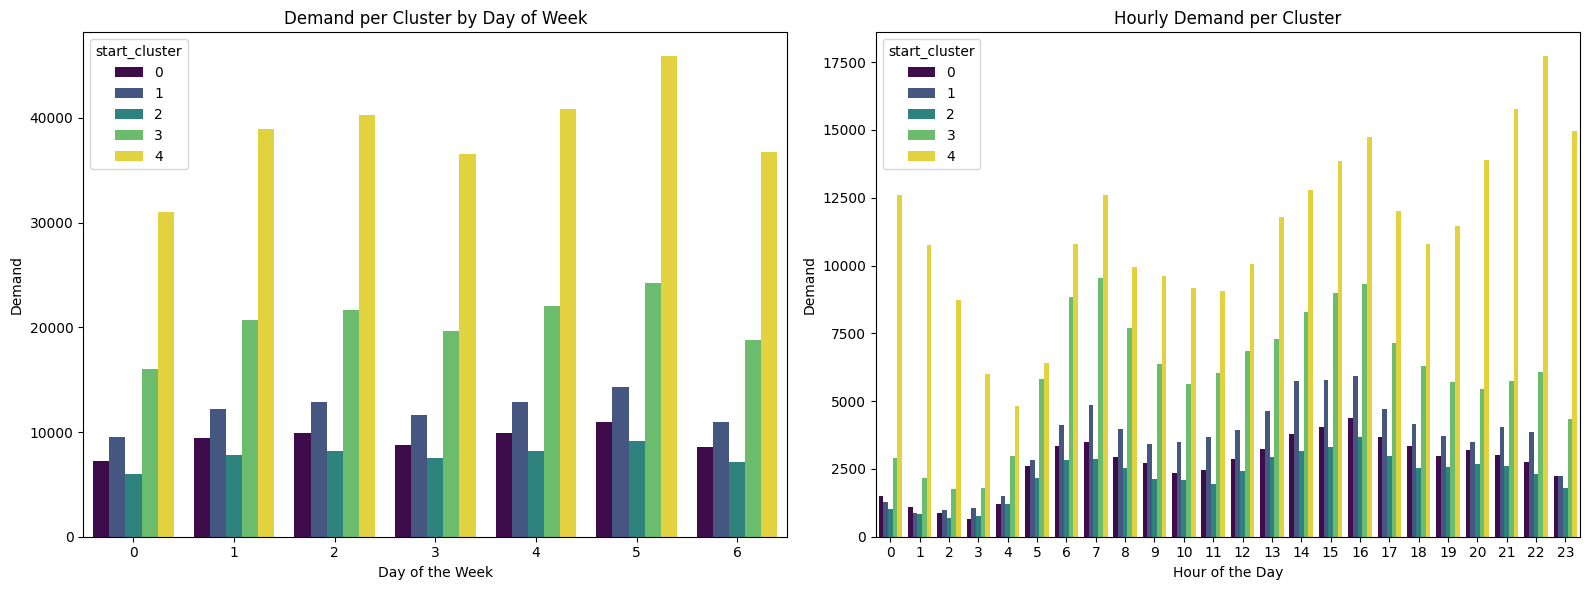

In [17]:
# Visualizing the demand

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x="day_of_week", y="demand", hue="start_cluster", 
            data=requests_per_cluster_per_weekday, 
            palette="viridis",
            ax=axes[0])
axes[0].set_title("Demand per Cluster by Day of Week")
axes[0].set_xlabel("Day of the Week")
axes[0].set_ylabel("Demand")

sns.barplot(x="hour_of_day", y="demand", hue="start_cluster", 
            data=requests_per_cluster_per_hour, 
            palette="viridis",
            ax=axes[1])
axes[1].set_title("Hourly Demand per Cluster")
axes[1].set_xlabel("Hour of the Day")
axes[1].set_ylabel("Demand")

plt.tight_layout()
plt.show()

---
# 7. <a id='toc7_'></a>[Building a Baseline Model](#toc0_)

>Build a baseline model to allocate supply efficiently.

In [18]:
data = rides_df.groupby(["start_cluster", "hour_of_day", "day_of_week"])["start_cluster"]\
    .count().reset_index(name="demand")

In [19]:
data.rename(columns={"start_cluster":"cluster"}, inplace=True)

In [20]:
# Features and target variable
data = rides_df.groupby(["start_cluster", "hour_of_day", "day_of_week"])["start_cluster"]\
    .count().reset_index(name="demand")

data.rename(columns={"start_cluster":"cluster"}, inplace=True)

features = data[["cluster", "hour_of_day", "day_of_week"]]
target = data["demand"]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

model = RandomForestRegressor(random_state=42, criterion="squared_error")
model.fit(X_train, y_train)

# Make predictions on the validation set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 8461.44103611111


## 7.1. <a id='toc7_1_'></a>[Allocating Resources](#toc0_)

> Now we have the model and we can predict the demand given a cluster, day of the week and hour of the day.
> To allocate the resource we can get the prediction for each cluster and allocate based on the rate `cluster demand/total demand`

In [21]:
def allocate_drivers(timestamp: datetime) -> dict:
    day_of_week = timestamp.weekday()
    hour_of_day = timestamp.hour

    predictions = []
    for cluster in range(n_clusters):
        input_data = pd.DataFrame([{'cluster': cluster, 'hour_of_day': hour_of_day, 'day_of_week': day_of_week}])
        prediction = model.predict(input_data)
        predictions.append(prediction[0])

    return {f"cluster_{i}":f"{(p/sum(predictions)):.2%}" for i, p in enumerate(predictions)}

> A real case scenario would be to get a future timestamp and provide the allocation ratios as below:

In [22]:
# Current timestamp
allocate_drivers(datetime.now() + timedelta(hours=2))

{'cluster_0': '10.71%',
 'cluster_1': '16.03%',
 'cluster_2': '9.83%',
 'cluster_3': '24.78%',
 'cluster_4': '38.65%'}

In [23]:
# Random timestamp in the future
random_timestamp = "01/02/2024 22:55:26"
allocate_drivers(datetime.strptime(random_timestamp, '%d/%m/%Y %H:%M:%S'))

{'cluster_0': '8.37%',
 'cluster_1': '11.78%',
 'cluster_2': '7.38%',
 'cluster_3': '19.64%',
 'cluster_4': '52.84%'}

## 7.2. <a id='toc7_2_'></a>[Design and Deployment of the Model](#toc0_)

>Having built a baseline model for efficient supply allocation, the next steps involve designing the model for deployment in a real-time environment and considering the necessary tools for deployment.
>
>*A drawback of this model is that we are considering each record to be demand, but the actual demand could have been higher since these are effectively accepted orders.*

## 7.3. <a id='toc7_3_'></a>[Model Documentation](#toc0_)

>Before deployment, it's crucial to document the model, including its features, target variable, training methodology, and evaluation metrics.

### 7.3.1. <a id='toc7_3_1_'></a>[Baseline Model Information:](#toc0_)

>- Features: `cluster`, `hour_of_day`, `day_of_week`
>- Target Variable: `demand`
>- Model Type: Random Forest Regressor
>- Training Methodology: Train-test split with evaluation using Mean Squared Error

### 7.3.2. <a id='toc7_3_2_'></a>[Model Deployment Considerations](#toc0_)
>Consider the following aspects when deploying the model:
>
>- Scalability: Ensure that the deployment solution can handle real-time data for a large number of ride requests.
>- Latency: Minimizing the service response time.
>- Robustness: Account for potential variations in data and traffic patterns, possible exceptions, and unit tests.
>- Monitoring: Implement mechanisms for continuous monitoring of the supply allocation system, ensuring adaptability to changing patterns and conditions.
>- Appropriate tools and frameworks for model deployment, common choices include FastAPI or Flask for building APIs, containerization with Docker, and orchestration with Kubernetes.

### 7.3.3. <a id='toc7_3_3_'></a>[Communication of Model Recommendations](#toc0_)
>Once the model provides recommendations, it's essential to communicate these recommendations effectively to drivers, this could be done by:
>- In-app interface to provide directions to optimal regions for rides, using the calculated polygons and rates.
>- Provide insights on demand in the clusters.
>- In a real scenario, to increase drivers following the recommendation there could be incentives, such as increased ride value, early access to requests, and more profitable trips.

# 8. <a id='toc8_'></a>[Designing the Experiment for Validation](#toc0_)

>To ensure the effectiveness of the supply allocation solution in live operations, it's crucial to design an experiment that validates the impact of the model on the ride-hailing marketplace.

## 8.1. <a id='toc8_1_'></a>[Experimental Design](#toc0_)
>
>1. **Randomized Assignment:** Randomly assign a region to follow the model recommendations while keeping others as a control group, these regions should be independent and relocation of the drivers in that region should not impact other regions.
>   
>2. **Data Collection:** Collect data during the experiment, including key metrics *(more on that below)*.
>
>3. **Duration:** Determine the duration of the experiment, ensuring it is long enough to capture sufficient data for analysis, based on the number of users and region size.
>
>4. **Null Hypothesis (H0):** There is no significant difference in the metrics between the control group and the experimental group.
>
>5. **Alternative Hypothesis (H1):** The average idle time and waiting time in the experimental group is significantly different from the average ride value in the control group.

## 8.2. <a id='toc8_2_'></a>[Metrics for Evaluation](#toc0_)

>Define metrics that will be used to evaluate the impact of the model. Example metrics include:
>
>- **Ride Acceptance Rate:** Percentage of rides accepted by drivers.
>- **Waiting time:** Time between request and rider's arrival.
>- **Idle drivers:** Number of idle drivers.

## 8.3. <a id='toc8_3_'></a>[Analysis and Iteration](#toc0_)

>After the experiment, conduct a thorough analysis of the collected data. Compare the performance metrics between the group following model recommendations and the control group. Iterate on the model or deployment strategy based on the results.


---

# 9. <a id='toc9_'></a>[Conclusion](#toc0_)

>In this journey of optimizing supply allocation in ride-hailing, we have taken several steps, starting from data exploration to the design of an experiment for validation. Below is a summary of the key findings and insights gained:

## 9.1. <a id='toc9_1_'></a>[Key Findings](#toc0_)

>1. **Spatial Clustering:** Utilizing k-means clustering, we identified distinct spatial clusters that represent regions with similar ride demand patterns.
>
>2. **Polygon Generation:** Employing a convex hull, we generated non-overlapping polygons around each cluster, defining regions for efficient supply allocation.
>
>3. **Baseline Model:** We built a baseline model, using a random forest regressor, to predict demand, which allows us to allocate supply effectively within the identified regions.
>
>4. **Model Deployment:** Considering scalability and latency, we discussed the deployment and monitoring of the model and highlighted the importance of effective communication of recommendations to drivers.
>
>5. **Experiment Design:** We designed an experiment to validate the impact of the supply allocation model, emphasizing randomized assignment, data collection, and the definition of key metrics.

## 9.2. <a id='toc9_2_'></a>[Next Steps](#toc0_)

>1. **Experiment Analysis:** Conduct a thorough analysis of the experiment data, comparing performance metrics between the experimental and control groups.
>
>2. **Model Refinement:** Based on the experiment results, iterate on the model and deployment strategy to improve efficiency and effectiveness.
>
>3. **Continuous Monitoring:** Implement mechanisms for continuous monitoring of the supply allocation system, ensuring >adaptability to changing patterns and conditions.

>4. **Different Approach:** If we had more data available *(see below some examples)* the approach could be significantly different.

---

# 10. <a id='toc10_'></a>[Additional data that could prove useful](#toc0_)

> - **Waiting Time:**
>
>>The waiting time between requesting the time and the driver's arrival.
>
> - **Driver Availability:**
>
>>Data on the availability of drivers in different areas and at different times can impact supply allocation strategies.
>
> - **End Time:**
>
>>Ride end time.
>
> - **Currency:**
>
>>Ride value currency, so the dataset can be converted to a single currency.
>
> - **Weather Data:**
>
>>Weather conditions at the time of the ride could impact demand and driver availability. Include features such as temperature, precipitation, and visibility.
>  
> - **Traffic Data:**
>
>>Information about traffic conditions can help in predicting ride durations and optimizing driver routes. Include data on traffic congestion, road closures, or accidents.
>  
> - **Holiday and Special Event Data:**
>
>>Holidays and special events can significantly affect ride demand. Incorporating information about holidays, festivals, or major events in the city can provide valuable insights.
>  
> - **Public Transportation Data:**
>
>>Data on public transportation schedules and disruptions can be useful.
>
> - **Promotions and Discounts Data:**
>
>>Information about ongoing promotions, discounts, or marketing campaigns can impact rider behavior.
>
> - **Local Events and Festivals:**
>
>>Data on local events and festivals that may attract people to specific areas can be beneficial for predicting demand patterns.
>
> - **Population Density:**
>
>>Understanding the population density in different areas of the city can provide insights into areas with higher potential demand.


---

# 11. <a id='toc11_'></a>[References](#toc0_)

>[Joseph Magiya - Clustering GPS Coordinates and Forming Regions with Python](https://levelup.gitconnected.com/clustering-gps-co-ordinates-forming-regions-4f50caa7e4a1)

>[Akash Srivastava - Detecting Anomalies with Z-Scores: A Practical Approach](https://medium.com/@akashsri306/detecting-anomalies-with-z-scores-a-practical-approach-2f9a0f27458d)